In [66]:
from os import listdir
from os.path import isfile, join

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
# get spotify credentials
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id= '6426e18767ac42d78a9c08f41cacba65',
                                                     client_secret= '4a2cdab50e1c4ecd9fc62cae20664e29')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [68]:
# get all file names
# chordPath  = '/Users/aaronlevi/Documents/Insight2020/chordRec/chords/'
chordPath  = '/Users/aaronlevi/Documents/Insight2020/chordRec/ug_chords/'

chordFiles = [f for f in listdir(chordPath) if isfile(join(chordPath, f))]

chordFiles.remove('.DS_Store')

In [69]:
# put together a list of various standard major & minor chords
sl1 = ['A', 'Bb', 'B', 'C', 'C#', 'Db', 'D', 'Eb', 'E', 'F', 'F#', 'G', 'G#', 'Ab' ]
sl2 = [s + 'maj' for s in sl1]
sl3 = [s + 'm' for s in sl1]
sl4 = [s + 'min' for s in sl1]

standardList = sl1+sl2+sl3+sl4

In [127]:
# load each song csv, get some metrics
nUniqueChords   = []
nHardChords     = []
difficultyLabel = []

spotFeatures = {}

spotFeatures['key'] = []
spotFeatures['tempo'] = []
spotFeatures['duration_ms'] = []
spotFeatures['time_signature'] = []
spotFeatures['energy'] = []

for iSong in range(0, len(chordFiles)):
#     dfSong = pd.read_csv(chordPath+chordFiles[iSong])
    dfSong = pd.read_csv(chordPath+chordFiles[iSong], sep='delimiter', header=None)

    songName   = dfSong[0][0].split(',')[1].replace('-', ' ').title()
    artistName = dfSong[0][1].split(',')[1].replace('-', ' ').title()
    
    difficultyLabel.append(dfSong[0][3].split(',')[1])
    
#     if dfSong.size==3:
    uniqChords = dfSong[0][2].split(',')[1:]
    nUniqueChords.append(len(uniqChords))

    tmpHard = []
    for kCh in range(0, nUniqueChords[iSong]):
        tmpHard.append(uniqChords[kCh] in standardList)

    nHardChords.append(sum(tmpHard));
    
    # search song in spotify api
    result = sp.search(songName) #search query
    nItems = len(result['tracks']['items'])

    # match artist info, and get URI
    for iArtist in range(0, nItems):    
        if result['tracks']['items'][iArtist]['artists'][0]['name'] == artistName:
           songURI = result['tracks']['items'][iArtist]['uri']

    # pull audio features for a songURI
    features = sp.audio_features(songURI)

    spotFeatures['key'].append(features[0]['key'])
    spotFeatures['tempo'].append(features[0]['tempo'])
    spotFeatures['duration_ms'].append(features[0]['duration_ms'])
    spotFeatures['time_signature'].append(features[0]['time_signature'])
    spotFeatures['energy'].append(features[0]['energy'])


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  app.launch_new_instance()


//anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


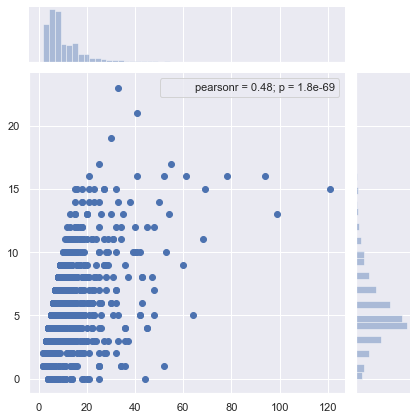

In [186]:
import scipy.stats as stats

sns.set(style="darkgrid", color_codes=True)
h = sns.jointplot(nUniqueChords, nHardChords)
h.annotate(stats.pearsonr)
plt.show()


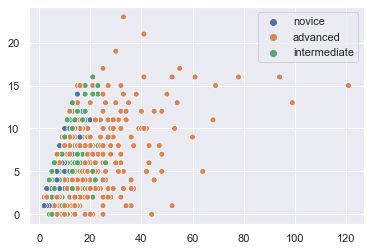

In [187]:
sns.scatterplot(nUniqueChords, nHardChords, hue=difficultyLabel)

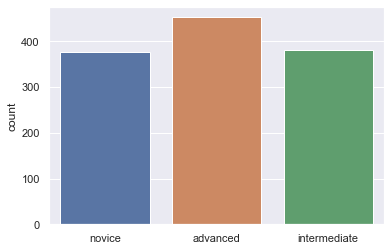

In [193]:
sns.countplot(difficultyLabel)

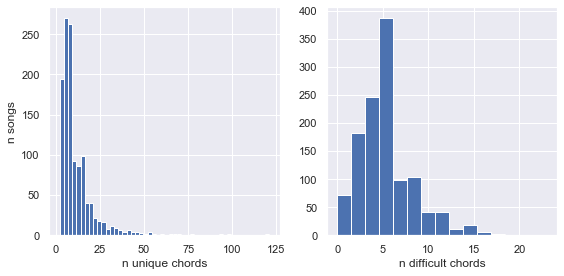

In [82]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))

ax[0].hist(nUniqueChords, bins=50)
ax[0].set_xlabel('n unique chords')
ax[0].set_ylabel('n songs')

ax[1].hist(nHardChords, bins=15)
ax[1].set_xlabel('n difficult chords')

plt.tight_layout()

In [83]:
[np.median(nUniqueChords), np.median(nHardChords)]

[8.0, 5.0]

In [194]:
sns.scatterplot(nUniqueChords[difficultyLabel=='novice'], nHardChords[difficultyLabel=='novice'])

ValueError: If using all scalar values, you must pass an index

In [166]:
spotFeatures = pd.DataFrame.from_dict(spotFeatures)
spotFeatures.head()

,key,tempo,duration_ms,time_signature,energy
0,11,110.0,227240,4,0.781
1,11,110.0,227240,4,0.781
2,11,110.0,227240,4,0.781
3,11,110.0,227240,4,0.781
4,11,110.0,227240,4,0.781


In [18]:
allFeatures = spotFeatures

allFeatures['n_unique_chords']    = nUniqueChords
allFeatures['n_difficult_chords'] = nHardChords

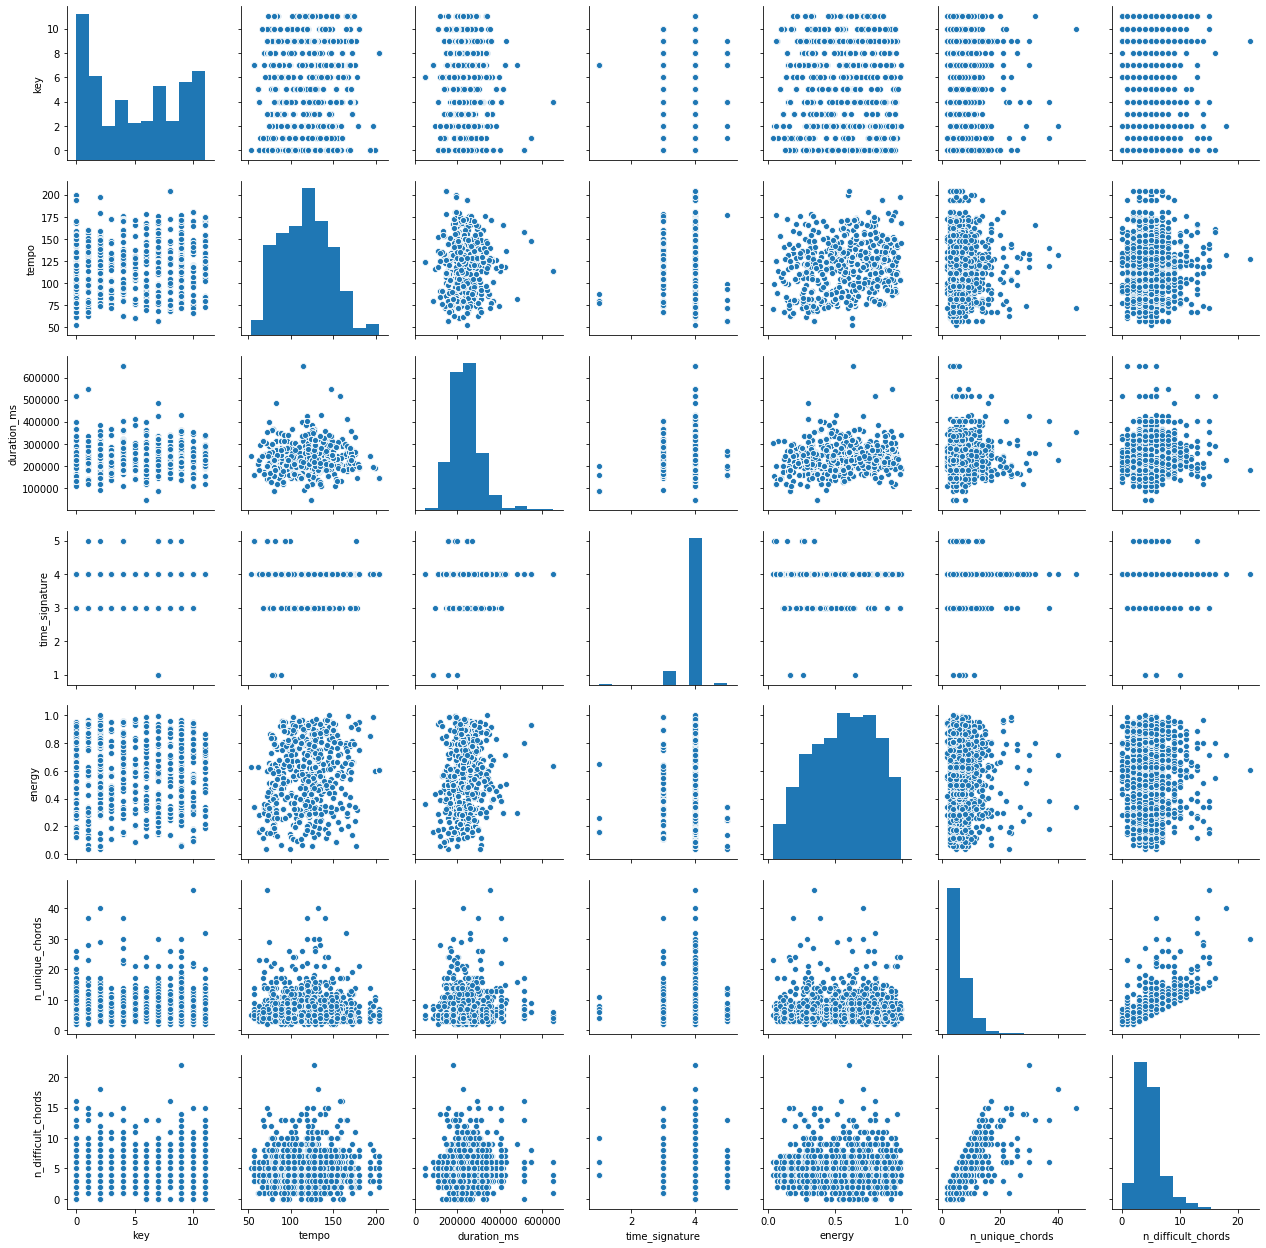

In [19]:
sns.pairplot(allFeatures)

In [20]:
allFeatures.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1823 entries, 0 to 1822
Data columns (total 7 columns):
key                   1823 non-null int64
tempo                 1823 non-null float64
duration_ms           1823 non-null int64
time_signature        1823 non-null int64
energy                1823 non-null float64
n_unique_chords       1823 non-null int64
n_difficult_chords    1823 non-null int64
dtypes: float64(2), int64(5)
memory usage: 99.8 KB


In [38]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
# kmeans.fit(allFeatures)

dfFeatures = allFeatures.drop(['key', 'duration_ms', 'energy'], axis=1)
kmeans.fit(allFeatures)

# kmeans.cluster_centers_
# kmeans.labels_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

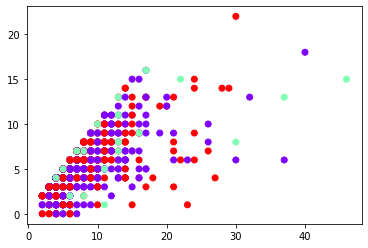

In [40]:
# f, ax1 = plt.figure(figsize=(10,10))

# ax1.set_title('K-Means assignments')
# ax1.scatter(allFeatures['n_unique_chords'],allFeatures['n_difficult_chords'],c=kmeans.labels_,cmap='rainbow')

plt.scatter(allFeatures['n_unique_chords'],allFeatures['n_difficult_chords'],c=kmeans.labels_,cmap='rainbow')
# plt.scatter(allFeatures['n_unique_chords'],allFeatures['time_signature'],c=kmeans.labels_,cmap='rainbow')


In [93]:
dfSong = pd.read_csv(chordPath+chordFiles[iSong], sep='delimiter', header=None)
dfSong

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


,0
0,"Song,i-will"
1,"Artist,tom-booth"
2,"Chords,C#m,C#M,F#,B,G#,E,F#m,Am,E7,A"
3,"Label,advanced"


In [76]:
# dfSong[0][3].split(',')[1]
dfSong

,0
0,"Song,i-will"
1,"Artist,tom-booth"
2,"Chords,C#m,C#M,F#,B,G#,E,F#m,Am,E7,A"
3,"Label,advanced"


In [169]:
artistName = dfSong[0][1].split(',')[1].replace('-', ' ').title()
songName   = dfSong[0][0].split(',')[1].replace('-', ' ').title()

[artistName, songName]

['Tom Booth', 'I Will']

In [94]:
difficultyLabel

['novice',
 'advanced',
 'intermediate',
 'novice',
 'novice',
 'advanced',
 'novice',
 'novice',
 'intermediate',
 'novice',
 'advanced',
 'novice',
 'advanced',
 'intermediate',
 'novice',
 'advanced',
 'novice',
 'novice',
 'novice',
 'novice',
 'advanced',
 'advanced',
 'advanced',
 'intermediate',
 'novice',
 'intermediate',
 'novice',
 'advanced',
 'novice',
 'advanced',
 'novice',
 'advanced',
 'intermediate',
 'advanced',
 'advanced',
 'novice',
 'intermediate',
 'novice',
 'intermediate',
 'advanced',
 'advanced',
 'advanced',
 'advanced',
 'advanced',
 'novice',
 'novice',
 'advanced',
 'intermediate',
 'intermediate',
 'advanced',
 'intermediate',
 'novice',
 'novice',
 'intermediate',
 'advanced',
 'intermediate',
 'advanced',
 'novice',
 'intermediate',
 'advanced',
 'advanced',
 'novice',
 'novice',
 'novice',
 'advanced',
 'advanced',
 'advanced',
 'advanced',
 'advanced',
 'advanced',
 'novice',
 'advanced',
 'intermediate',
 'novice',
 'novice',
 'intermediate',
 'novi

In [114]:
    # search song in spotify api
    result = sp.search(songName) #search query
    nItems = len(result['tracks']['items'])

#     # match artist info, and get URI
#     for iArtist in range(0, nItems):    
#         if result['tracks']['items'][iArtist]['artists'][0]['name'] == artistName:
#            songURI = result['tracks']['items'][iArtist]['uri']

In [119]:
result['tracks']['items'][iArtist]

{'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/3WrFJ7ztbogyGnTHbHJFl2'},
    'href': 'https://api.spotify.com/v1/artists/3WrFJ7ztbogyGnTHbHJFl2',
    'id': '3WrFJ7ztbogyGnTHbHJFl2',
    'name': 'The Beatles',
    'type': 'artist',
    'uri': 'spotify:artist:3WrFJ7ztbogyGnTHbHJFl2'}],
  'available_markets': ['AD',
   'AE',
   'AL',
   'AR',
   'AT',
   'AU',
   'BA',
   'BE',
   'BG',
   'BH',
   'BO',
   'BR',
   'BY',
   'CA',
   'CH',
   'CL',
   'CO',
   'CR',
   'CY',
   'CZ',
   'DE',
   'DK',
   'DO',
   'DZ',
   'EC',
   'EE',
   'EG',
   'ES',
   'FI',
   'FR',
   'GB',
   'GR',
   'GT',
   'HK',
   'HN',
   'HR',
   'HU',
   'ID',
   'IE',
   'IL',
   'IN',
   'IS',
   'IT',
   'JO',
   'JP',
   'KW',
   'KZ',
   'LB',
   'LI',
   'LT',
   'LU',
   'LV',
   'MA',
   'MC',
   'MD',
   'ME',
   'MK',
   'MT',
   'MX',
   'MY',
   'NI',
   'NL',
   'NO',
   'NZ',
   'OM',
   'PA',
   'PE',
   'PH',
   'PL',
   'PS',


In [170]:
track_id = sp.search(q='artist:' + artistName + ' track:' + songName, type='track')

In [159]:
[artistName, songName]

['tom booth', 'i will']

In [112]:
artistName = artistName.replace('-', ' ')
songName = songName.replace('-', ' ')

In [115]:
songURI

'spotify:track:1oTo3ijRbaDAtrjJrGAPSw'

In [139]:
track_id['tracks']['items'][0]['artists'][0]['name'].lower() == artistName

True

In [182]:
track_id['tracks']['items'][1]['artists'][0]['uri']

'spotify:artist:0fBK9SSzz8NOZppc9TmDnE'

In [200]:
difficultyLabel=='novice'

False